code to produce diurnal cycle of temperature, humidity, lhf and shf
author: Claudia Acquistapace
date: 16 Nov 2021


In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
def f_closest(array,value):
    '''
    # closest function
    #---------------------------------------------------------------------------------
    # date :  16.10.2017
    # author: Claudia Acquistapace
    # goal: return the index of the element of the input array that in closest to the value provided to the function
    '''
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    return idx  



# output paths
path_out = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings to be used
labelsizeaxes   = 14
fontSizeTitle   = 16
fontSizeX       = 16
fontSizeY       = 16
cbarAspect      = 10
fontSizeCbar    = 16
rcParams['font.sans-serif'] = ['Tahoma']
matplotlib.rcParams['savefig.dpi'] = 100
plt.rcParams.update({'font.size':22})
grid = True

# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'WVMR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]




processing var : T


<ipython-input-6-3b2b6af89a58>:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0].pcolormesh(pd.to_datetime(data_clean['Time'].values), data_clean['Height'].values, \
/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-6-3b2b6af89a58>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[1].pcolormesh(pd

NameError: name 'strasukamelo' is not defined

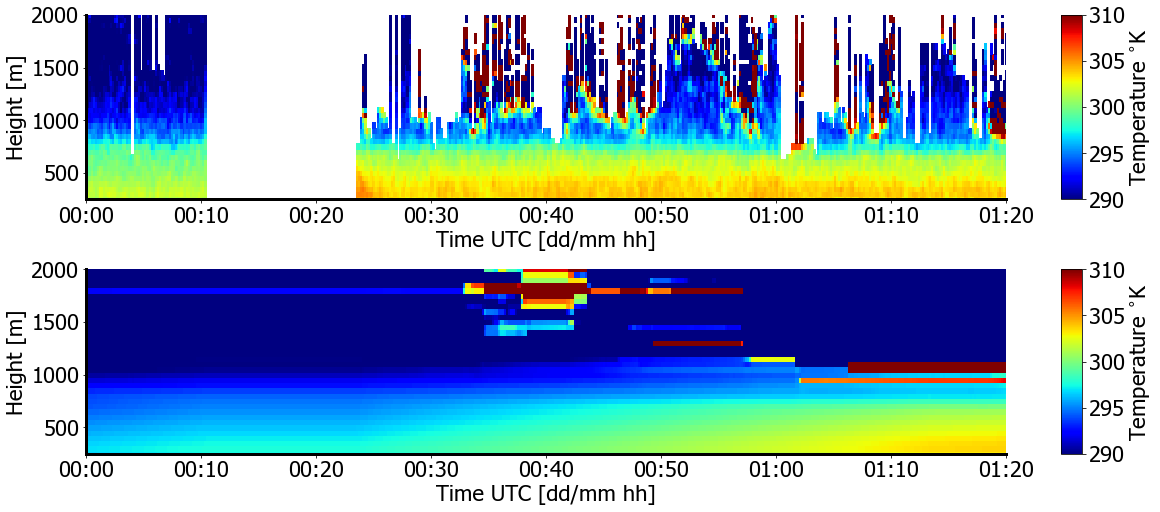

In [6]:

for ind_var,var_name in enumerate(var_list[0]):
    
    # read dictionary for the variable
    dict_var = dict_list[ind_var]
    
    # print var processed
    print('processing var : '+str(dict_var['var_name']))
    
    
    # paths
    data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'

    arthus_files = np.sort(glob.glob(data_path+'*.cdf'))
    
    # merging data from each day in a single xarray dataset
    arthus_data = xr.open_mfdataset(arthus_files)
    
    # reading noise mask file and remove noise from the variable
    noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
    noise_mask = xr.open_dataset(noise_mask_file)
    height_thr = noise_mask.cloud_base_height.values+100.
    
    # interpolating time of the arthus product on the time of the noise mask
    arthus_data_interp = arthus_data.interp(Time=noise_mask['Time'].values)

    # find closest height of arthus data to the threshold height for every time stamp
    arthus_height_thr = []
    for ind_t in range(len(arthus_data_interp.Time.values)):
        arthus_height_thr.append(arthus_data_interp['Height'].values[f_closest(arthus_data_interp['Height'].values, height_thr[ind_t])])    
    
    # building noise mask for arthus_data
    mask = np.zeros((len(pd.to_datetime(arthus_data_interp['Time'].values)),len(arthus_data_interp['Height'].values)))
    for ind in range(len(pd.to_datetime(arthus_data_interp['Time'].values))):    
        ind_zero = np.where(arthus_data_interp['Height'].values > arthus_height_thr[ind])
        mask[ind,ind_zero[0]] = 1.
    
    # creating a dataset for the variable mask 
    dims             = ['Time','Height']
    coords           = {"Time":pd.to_datetime(arthus_data_interp['Time'].values), "Height":arthus_data_interp['Height'].values}
    mask_noise       = xr.DataArray(dims=dims, coords=coords, data=mask,\
                         attrs={'long_name':'noise mask for arthus data',\
                                'units':''})
    noise_mask_new    = xr.Dataset(data_vars = {'noise_mask':mask_noise},
                                  coords = coords)
    
    # merging dataset of arthus data and of noise mask
    merged_data = xr.merge([arthus_data_interp, noise_mask_new])
    
    # filtering the arthus product variable using the where function and the mask
    data_clean = merged_data.Product.where(merged_data.noise_mask.values == 0., np.nan)
    

    # calculating outliers
    # calculation of rolling mean over 1 h 
    running_mean = data_clean.rolling(min_periods=1, Time=360).mean()  
    running_std = data_clean.rolling(min_periods=1, Time=360).std() 
    
    # plot of merged data time serie before removal of the noise
    fig, axs = plt.subplots(3, 1, figsize=(16,7), constrained_layout=True)
    axs[0].get_yaxis().tick_left()
    axs[0].get_xaxis().tick_bottom() 
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_linewidth(3)
    axs[0].spines["left"].set_linewidth(3)
    
    mesh = axs[0].pcolormesh(pd.to_datetime(data_clean['Time'].values), data_clean['Height'].values, \
                             data_clean.values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

    cbar = fig.colorbar(mesh, ax=axs[0], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
    axs[0].set_ylim(250., 2000.)
    axs[0].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
    axs[0].set_xlabel('Time UTC [dd/mm hh]')
    axs[0].set_ylabel('Height [m]')
    
    
    axs[1].get_yaxis().tick_left()
    axs[1].get_xaxis().tick_bottom() 
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_linewidth(3)
    axs[1].spines["left"].set_linewidth(3)
    
    mesh = axs[1].pcolormesh(pd.to_datetime(running_mean['Time'].values), running_mean['Height'].values, \
                         running_mean.values.T, vmin=dict_var['var_min'], \
                         vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)


    cbar = fig.colorbar(mesh, ax=axs[1], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
    axs[1].set_ylim(250., 2000.)
    axs[1].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
    axs[1].set_xlabel('Time UTC [dd/mm hh]')
    axs[1].set_ylabel('Height [m]')
    

    
    axs[2].get_yaxis().tick_left()
    axs[2].get_xaxis().tick_bottom() 
    axs[2].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["bottom"].set_linewidth(3)
    axs[2].spines["left"].set_linewidth(3)
    
    mesh = axs[2].pcolormesh(pd.to_datetime(running_std['Time'].values), running_std['Height'].values, \
                         running_std.values.T, vmin=dict_var['var_min'], \
                         vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)


    cbar = fig.colorbar(mesh, ax=axs[2], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
    axs[2].set_ylim(250., 2000.)
    axs[2].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
    axs[2].set_xlabel('Time UTC [dd/mm hh]')
    axs[2].set_ylabel('Height [m]')
    
    
    fig.savefig(path_out+'{var_name}_time_serie_no_noise.png'.format(**dict_var))

    strasukamelo

    

In [11]:
# diurnal cycle calculation: averaging the data on the time resolution of the diurnal cycle and then grouping

    # calculating the mean of the variable over the time interval requested
    arthus_data = arthus_data.resample(Time=dict_var['avg_time']+'T').mean()

    # re-writing time array as hh:mm for then being able to group
    arthus_data['Time'] = pd.to_datetime(arthus_data.Time.values).strftime("%H:%M")

    # grouping and calculating mean of the profiles
    grouped_mean = arthus_data.groupby('Time').mean()
    grouped_std = arthus_data.groupby('Time').std()
    
    # plot figure of the diurnal cycle variable
    fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    #ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
    #ax.tick_params(which='minor', length=7, width=3)
    #ax.tick_params(which='major', length=7, width=3)

    mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \
                             grouped_mean['Product'].values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

    cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs.set_ylim(250., 2000.)

    axs.set_xlabel('Time UTC [HH:MM]')
    axs.set_ylabel('Height [m]')
    axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
            fontweight='black', transform=axs.transAxes)
    fig2.savefig(path_out+'{var_name}_diurnal_cycle.png'.format(**dict_var))

<xarray.DataArray 'Product' (Time: 61657, Height: 57)>
dask.array<where, shape=(61657, 57), dtype=float32, chunksize=(61657, 57), chunktype=numpy.ndarray>
Coordinates:
  * Height   (Height) float32 225.0 275.0 325.0 375.0 ... 2925.0 2975.0 3025.0
  * Time     (Time) datetime64[ns] 2020-01-28T00:00:05 ... 2020-02-04T23:59:48
Attributes:
    long_name:      Temperature
    standard_name:  Temperature
    units:          K

In [8]:
running_mean = data_clean.rolling(min_periods=1, Time=360).mean()
running_std =  data_clean.rolling(min_periods=1, Time=360).std()

In [9]:
np.nanmax(running_std.values)

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


129714.3

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-47-3f0cf7586b8a>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs.pcolormesh(pd.to_datetime(running_mean['Time'].values), running_mean['Height'].values, \


Text(0, 0.5, 'Height [m]')

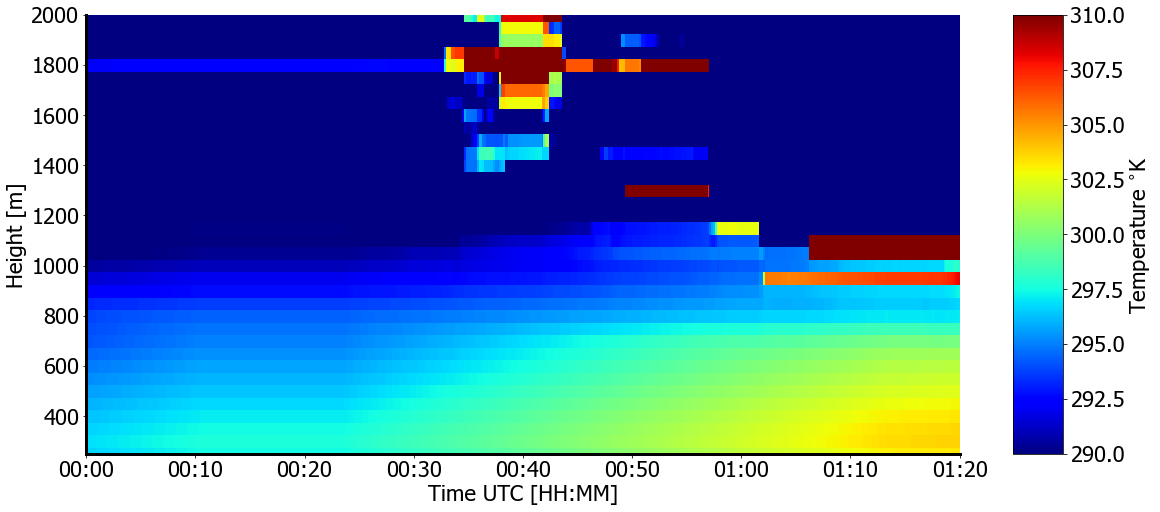

In [47]:
 # plot figure of the diurnal cycle variable
fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
#ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
#ax.tick_params(which='minor', length=7, width=3)
#ax.tick_params(which='major', length=7, width=3)

mesh1 = axs.pcolormesh(pd.to_datetime(running_mean['Time'].values), running_mean['Height'].values, \
                         running_mean.values.T, vmin=dict_var['var_min'], \
                         vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                    location='right', aspect=20, use_gridspec=grid)
axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs.set_ylim(250., 2000.)
axs.set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))

axs.set_xlabel('Time UTC [HH:MM]')
axs.set_ylabel('Height [m]')

#fig2.savefig(path_out+'{var_name}_diurnal_cycle.png'.format(**dict_var))

In [8]:
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/VW/'
arthus_files = np.sort(glob.glob(data_path+'*.cdf'))
    
# merging data from each day in a single xarray dataset
# arthus_data = xr.open_mfdataset(arthus_files)
arthus_data = xr.open_dataset(arthus_files[0])

<ipython-input-4-90f851dc2fc3>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)


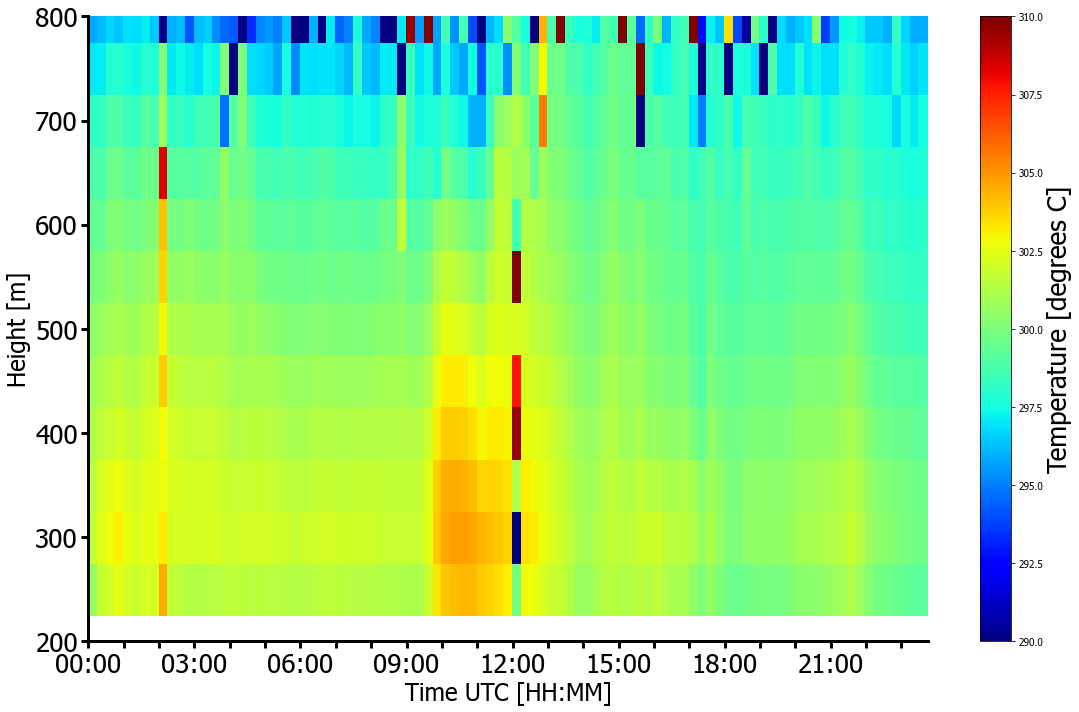

In [4]:
# reading variables for the plot and deriving the plot
T = grouped_mean.Product.values
time = grouped_mean.Time.values
height = grouped_mean.Height.values


labelsizeaxes   = 26
fontSizeTitle   = 26
fontSizeX       = 26
fontSizeY       = 26
cbarAspect      = 26
fontSizeCbar    = 26
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
rcParams['font.sans-serif'] = ['Tahoma']
matplotlib.rcParams['savefig.dpi'] = 100
plt.gcf().subplots_adjust(bottom=0.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
ax.tick_params(which='minor', length=7, width=3)
ax.tick_params(which='major', length=7, width=3)

#ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.tick_params(axis='both', labelsize=26)

mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)
ax.set_xlabel('Time UTC [HH:MM]', fontsize=24)
ax.set_ylabel('Height [m]', fontsize=24)
ax.set_ylim(200., 800.)
cbar = fig.colorbar(mesh1, use_gridspec=True)
cbar.set_label(label='Temperature [degrees C]',  size=26)

fig.tight_layout()
fig.savefig(path_out+'T_diurnal_cycle.png')


<ipython-input-41-54a0cdcfe7d0>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)


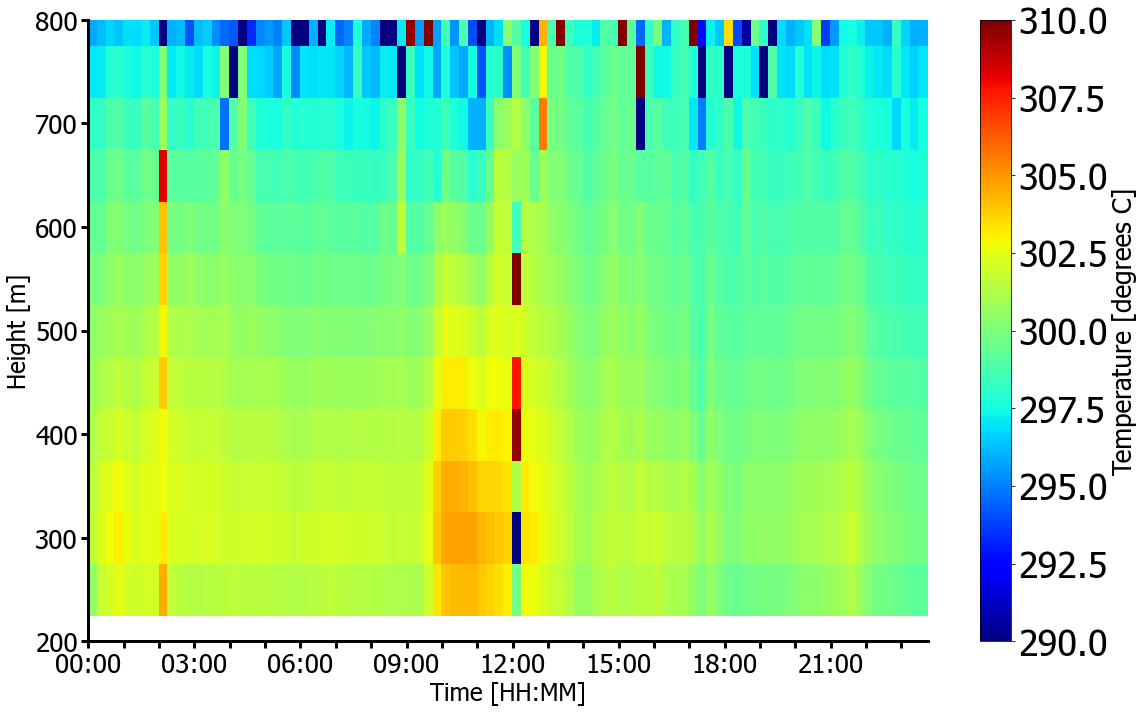